# Apply a spectral sea level equation solver to a continental surface  load
*Author: R. Rietbroek Nov 2024 (r.rietbroek@utwente.nl)*
When a surface load, e.g. a changing glacier load, is applied on the crust of the Earth it induces changes in gravity and a deformation of teh Earth. A passive but self-consistent ocean responds by adapting to the new geoid but also enforces a mass conservation (e.g. the mass from the melting glacier should be added to the ocean). This are generally considered Self Attraction and Loading (SAL) effects.

For a given surface load, the computation of a SAL response of the ocean can be done by solving the sea level equation. This is what is shown in this notebook.

## 1. Setup the spectral sea level equation solver

In [1]:
#Optionally enable autoreloading for development purposes. Note that this does not automagically reload the binary extensions
%load_ext autoreload
%autoreload 2

In [7]:
from shxarray.earth.sealevel import SpectralSeaLevelSolver
import xarray as xr
import os
import requests
from shxarray.kernels.axial import ParabolicCap

In [8]:
#set the maximum degree of the sea level equation solver
nmax=60

In [9]:
#load an ocean function in spherical harmonics
url="https://github.com/strawpants/geoshapes/raw/refs/heads/master/raster/ocean/ne_10m_oceansh_n300.nc"
#temporary storage
outfile="/tmp/"+os.path.basename(url)
if not os.path.exists(outfile):
    r = requests.get(url)
    print(f"Downloading ocean SH coefficients {outfile}")
    with open(outfile,'wb') as fid:
        fid.write(r.content)
else:
    print(f"{outfile}, already downloaded")


dsoce=xr.open_dataset(outfile)
#note: ocean coefficients need to be supported up to 2*nmax
dsoce=dsoce.sh.truncate(nmax=nmax*2)
display(dsoce)

<xarray.Dataset> Size: 351kB
Dimensions:  (nm: 14641)
Coordinates:
    n        (nm) int64 117kB 0 1 1 1 2 2 2 2 ... 120 120 120 120 120 120 120
    m        (nm) int64 117kB ...
Dimensions without coordinates: nm
Data variables:
    oceansh  (nm) float64 117kB ...

In [30]:
sle=SpectralSeaLevelSolver(dsoce.oceansh)
sle_rot=SpectralSeaLevelSolver(dsoce.oceansh,rotfeedback=True)
# display(sle.dsearth)

shxarray-INFO: /home/roelof/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)
shxarray-INFO: /home/roelof/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)
shxarray-INFO: Reading ocean function from cache: /home/roelof/.cache/shxarray_storage/P2S/p2s_ocean_n60.nc
shxarray-INFO: /home/roelof/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)
shxarray-INFO: /home/roelof/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)
shxarray-INFO: Reading ocean function from cache: /home/roelof/.cache/shxarray_storage/P2S/p2s_ocean_n60.nc


In [11]:
# create a parabolic cap load to test the sea level equation with

capkernel=ParabolicCap(nmax=nmax,psi=4)
#Antarctica Pine Island glacier location:
 
lat=-75.56279516301238
lon=-97.02379918735397
# position the unit loads on the specified locations on the sphere
dapine=capkernel.position(lon=lon,lat=lat)
display(dapine)

<xarray.DataArray 'shcap' (nm: 3721)> Size: 30kB
array([-8.37710719e-41,  2.86734045e-40, -2.36245390e-39, ...,
        4.00567201e-40, -3.30034595e-39,  4.56204700e-41])
Coordinates:
  * nm       (nm) object 30kB MultiIndex
  * n        (nm) int32 15kB 60 59 60 58 59 60 57 58 ... 59 60 58 59 60 59 60 60
  * m        (nm) int32 15kB -60 -59 -59 -58 -58 -58 -57 ... 58 58 58 59 59 60
    lon      float64 8B -97.02
    lat      float64 8B -75.56

In [31]:
sal_resp=sle(dapine)
sal_resp_rot=sle_rot(dapine)
display(sal_resp)

current mass inconsistency: iteration 0, relratio:-0.04207637227043774,dphi_g: -0.0010955495550504096
current mass inconsistency: iteration 1, relratio:-0.003081154084491302,dphi_g: -0.001092209255615007
current mass inconsistency: iteration 2, relratio:0.001177214833939533,dphi_g: -0.0010934854819695892
current mass inconsistency: iteration 3, relratio:0.0002639735488432745,dphi_g: -0.0010937716574324135
current mass inconsistency: iteration 4, relratio:2.8241481082761728e-06,dphi_g: -0.0010937747191099776
current mass inconsistency: iteration 0, relratio:-0.047589633135468,dphi_g: -0.0010895725926364287
current mass inconsistency: iteration 1, relratio:-0.004538155348093285,dphi_g: -0.0010846527485353803
current mass inconsistency: iteration 2, relratio:0.0010645516946176565,dphi_g: -0.001085806836038627
current mass inconsistency: iteration 3, relratio:0.0002750531713995521,dphi_g: -0.0010861050229932347
current mass inconsistency: iteration 4, relratio:3.4393486182566372e-06,dphi_g

<xarray.Dataset> Size: 238kB
Dimensions:     (nm: 3721)
Coordinates:
  * nm          (nm) object 30kB MultiIndex
  * n           (nm) int64 30kB 0 1 1 1 2 2 2 2 2 ... 60 60 60 60 60 60 60 60 60
  * m           (nm) int64 30kB 0 -1 0 1 -2 -1 0 1 2 ... 53 54 55 56 57 58 59 60
    lon         float64 8B -97.02
    lat         float64 8B -75.56
Data variables:
    quasi_sea   (nm) float64 30kB -0.001094 -7.828e-05 ... 7.685e-09 1.287e-08
    load_sea    (nm) float64 30kB -0.000812 1.177e-05 ... 4.637e-07 7.768e-07
    load_force  (nm) float64 30kB 0.000812 -0.0003477 ... -3.3e-39 4.562e-41
    geoid       (nm) float64 30kB 0.0 -6.246e-05 ... 2.034e-09 3.407e-09
    uplift      (nm) float64 30kB 0.0 1.582e-05 ... -5.651e-09 -9.467e-09

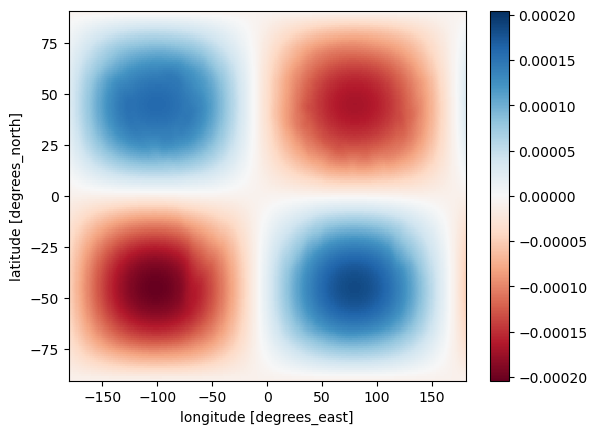

In [32]:
#some plots
ds_qs=sal_resp.quasi_sea.sh.synthesis()
ds_qs_rot=sal_resp_rot.quasi_sea.sh.synthesis()
(ds_qs-ds_qs_rot).plot(cmap='RdBu')

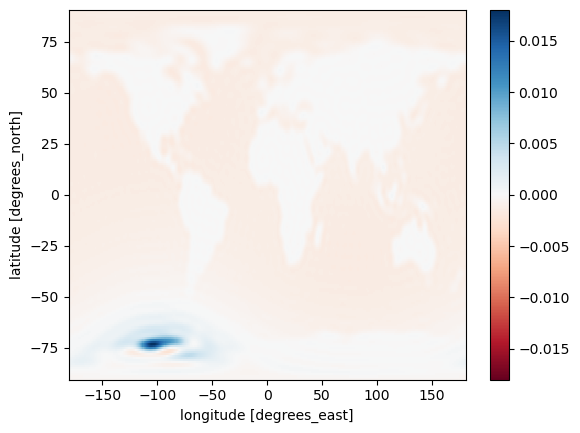

In [29]:
ds_rs=sal_resp.load_sea.sh.synthesis()
ds_rs.plot(cmap='RdBu')

In [5]:
from shxarray.earth.rotation import qs_rotfeedback_slow
mat=qs_rotfeedback_slow()

In [6]:
display(mat)

<xarray.DataArray (nm_: 3, nm: 4)> Size: 96B
array([[ 0.00054455, -0.0001406 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.07958336,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.07958336]])
Coordinates:
  * nm_      (nm_) object 24B MultiIndex
  * n        (nm_) int64 24B 2 2 2
  * m        (nm_) int64 24B 0 1 -1
  * nm       (nm) object 32B MultiIndex
  * n_       (nm) int64 32B 0 2 2 2
  * m_       (nm) int64 32B 0 0 1 -1